In [1]:
from itertools import islice
import json
import pathlib
import cv2
from ultralytics import YOLO
from dataset import RDDDataset
from tqdm import tqdm
from ultralytics.yolo.utils.plotting import Annotator
import matplotlib.pyplot as plt


In [2]:
train_idx = 200
model_file = (
        (pathlib.Path())
        / "../runs"
        / "detect"
        / f'train{train_idx if train_idx else ""}'
        / "weights"
        / "best.pt"
    )
print(model_file.absolute())

/cluster/home/constab/TDT4265_project/yolo/../runs/detect/train200/weights/best.pt


In [3]:
model = YOLO(model_file.absolute(), task="detect")

In [4]:
img_gen = RDDDataset.get_test_images()

Loading test images:   0%|          | 0/2040 [00:00<?, ?it/s]

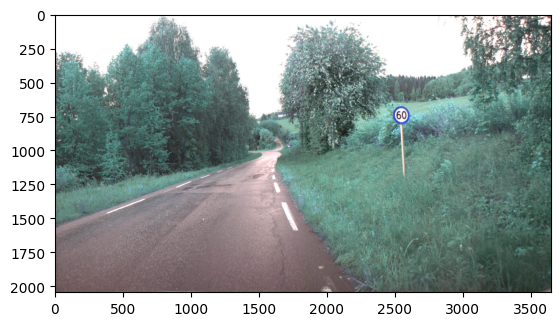

In [5]:
id_, im0 = img_gen.__next__()
plt.imshow(im0)

In [6]:
pred = model(im0)

pred2 = model(cv2.resize(im0, dsize=(640, 640)))


0: 384x640 1 d00, 54.2ms
Speed: 16.3ms preprocess, 54.2ms inference, 214.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 d00, 2 d20s, 15.8ms
Speed: 0.4ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


In [7]:
sz_x, sz_y = 640 * 2, 640 * 2

imgs_x = (im0.shape[1] // sz_x) + 2
imgs_y = (im0.shape[0] // sz_y) + 2
h, w = im0.shape[:2]
print((imgs_x, imgs_y))
print((w, h))

import numpy as np

dx = np.linspace(sz_x/2, w - sz_x/2, imgs_x)
dy = np.linspace(sz_y/2, h - sz_y/2, imgs_y)

(4, 3)
(3650, 2044)


In [8]:
print(dx)
print(dy)

[        640        1430        2220        3010]
[        640        1022        1404]


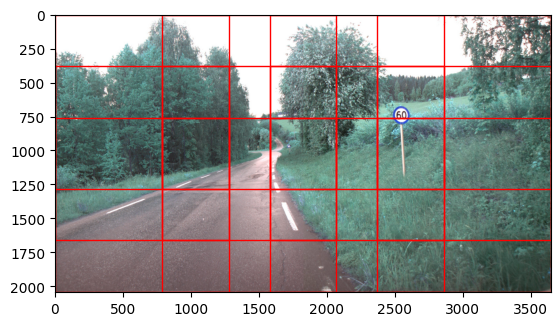

In [9]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.imshow(im0)
for x in dx:
    for y in dy:
        ax.add_patch(Rectangle((x - sz_x / 2, y - sz_y / 2), sz_x, sz_y,edgecolor='red',                   facecolor='none',
                               ))
plt.show()

In [10]:
from copy import deepcopy
from typing import Tuple

import torch


class ImageFragment:
    def __init__(self, img, center: Tuple[int, int]) -> None:
        self.im = img
        self.center = center
        self.shape = self.im.shape
        self.translate = torch.tensor([self.center[0] - self.shape[0] / 2, self.center[1] - self.shape[1] / 2]).cuda()
        
    def to_global_result(self, result):
        glob_res = deepcopy(result)
        for box in glob_res.boxes:
            box.xyxy[0, :2] += self.translate
            box.xyxy[0, 2:] += self.translate
            box.xywh[0, :2] += self.translate
        return glob_res

In [11]:
fragments = []
for x in dx:
    for y in dy:
        x_start = int(round(x - sz_x / 2))
        x_end = int(round(x + sz_x / 2))
        y_start = int(round(y - sz_y / 2))
        y_end = int(round(y + sz_y / 2))
        img_seg = im0[y_start:y_end,x_start:x_end]
        fragments.append(
            ImageFragment(
                img=img_seg,
                center=(int(round(x)), int(round(y)))
            )
        )

In [12]:
results = [
    (frag, model(frag.im)[0])
    for frag in fragments
]


0: 640x640 (no detections), 15.3ms
Speed: 0.6ms preprocess, 15.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.0ms
Speed: 0.3ms preprocess, 15.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.5ms
Speed: 0.3ms preprocess, 15.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.1ms
Speed: 0.3ms preprocess, 15.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 d20, 15.0ms
Speed: 0.3ms preprocess, 15.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.0ms
Speed: 0.3ms preprocess, 15.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.4ms
Speed: 0.3ms preprocess, 15.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.0ms
Speed: 0.3ms preprocess, 15.0ms inference, 

In [13]:
global_results = [
    frag.to_global_result(result)
    for frag, result in results
]

tensor([1468.4758, 1211.7665, 1636.1897, 1488.1862], device='cuda:0')
tensor([1649.3347, 1736.4470, 1705.5782, 2037.7131], device='cuda:0')
tensor([1656.5713, 1775.5157, 1701.9580, 2036.0807], device='cuda:0')


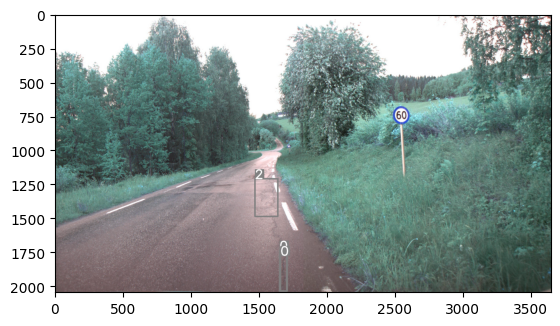

In [14]:
annotator = Annotator(im0)
for result in global_results:
    boxes = result.boxes
    for box in boxes:
        print(box.xyxy[0])
        b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
        c = box.cls
        annotator.box_label(b, str(int(c.item())))
frame = annotator.result()
plt.imshow(frame)


In [18]:
x = 3
import itertools
from typing import List
from ultralytics.yolo.engine.results import Boxes

def get_iou(box1, box2):
    """
    Implement the intersection over union (IoU) between box1 and box2
        
    Arguments:
        box1 -- first box, numpy array with coordinates (ymin, xmin, ymax, xmax)
        box2 -- second box, numpy array with coordinates (ymin, xmin, ymax, xmax)
    """
    # ymin, xmin, ymax, xmax = box
    
    x_left = max(box1[0].item(), box2[0].item())
    y_top = max(box1[1].item(), box2[1].item())
    x_right = min(box1[2].item(), box2[2].item())
    y_bottom = min(box1[3].item(), box2[3].item())

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

            # compute the area of both AABBs
    box1_area = (box1[2].item() - box1[0].item()) * (box1[3].item() - box1[1].item())
    box2_area = (box2[2].item() - box2[0].item()) * (box2[3].item() - box2[1].item())

            # compute the intersection over union by taking the intersection
            # area and dividing it by the sum of prediction + ground-truth
            # areas - the interesection area
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def get_merged_box(boxes) -> Boxes:
    conf = sum(b.conf for b in boxes) / len(boxes)
    cls_preds = {}
    for box in boxes:
        if box.cls.item() not in cls_preds:
            cls_preds[box.cls.item()] = box.conf.item()
        else:
            cls_preds[box.cls.item()] += box.conf.item()

    cls = max(cls_preds, key=cls_preds.get)
    
    return Boxes(
        torch.tensor(
                    [
                        min(box.xyxy[0][0] for box in boxes),
                        min(box.xyxy[0][1] for box in boxes),
                        max(box.xyxy[0][2] for box in boxes),
                        max(box.xyxy[0][3] for box in boxes),
                        conf,
                        cls
                    ]
                ),
        orig_shape=boxes[0].orig_shape
    )

def are_connected(box1, box2, iou_th = 0.25):
    if box1 == box2: return True
    iou = get_iou(box1.xyxy[0], box2.xyxy[0])
    if iou < iou_th: return False
    elif box1.cls == box2.cls:
        return True
    elif iou > min(iou_th * 1.5, 0.9):
        return True


def merge_boxes(boxes):
    result_set = []
    work_set = deepcopy(boxes)
    while work_set:
        connections = [
            [are_connected(b1, b2) for b2 in work_set]
            for b1 in work_set
        ]
        num_connections = [sum(conn) for conn in connections]
        
        if max(num_connections) <= 1:
            result_set.extend(work_set)
            break
        
        max_conn_idx = np.argmax(num_connections)
        merge_idx = [i for i, connected in  enumerate(connections[max_conn_idx]) if connected]
        boxes_to_merge = [work_set[i] for i in merge_idx]
        result_set.append(
            get_merged_box(boxes_to_merge)
        )
        [work_set.remove(box) for box in boxes_to_merge]
        
    return result_set

boxes = [box for res in global_results for box in res.boxes]
merged_boxes = merge_boxes(boxes)
print(merged_boxes)



WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


[ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[1.6493e+03, 1.7364e+03, 1.7056e+03, 2.0377e+03, 3.0896e-01, 0.0000e+00]])
cls: tensor([0.])
conf: tensor([0.3090])
data: tensor([[1.6493e+03, 1.7364e+03, 1.7056e+03, 2.0377e+03, 3.0896e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: tensor([1280, 1280])
shape: torch.Size([1, 6])
xywh: tensor([[1677.4565, 1887.0801,   56.2435,  301.2661]])
xywhn: tensor([[1.3105, 1.4743, 0.0439, 0.2354]])
xyxy: tensor([[1649.3347, 1736.4470, 1705.5782, 2037.7131]])
xyxyn: tensor([[1.2885, 1.3566, 1.3325, 1.5920]]), ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[1.4685e+03, 1.2118e+03, 1.6362e+03, 1.4882e+03, 2.8438e-01, 2.0000e+00]], device='cuda:0')
cls: tensor([2.], device='cuda:0')
conf: tensor([0.2844], device='cuda:0')
data: tensor([[1.4685e+03, 1.2118e+03, 1.6362e+03, 1.4882e+03, 2.8438e-01, 2.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: tensor([1280, 1280], 

tensor([1649.3347, 1736.4470, 1705.5782, 2037.7131])
tensor([1468.4758, 1211.7665, 1636.1897, 1488.1862], device='cuda:0')


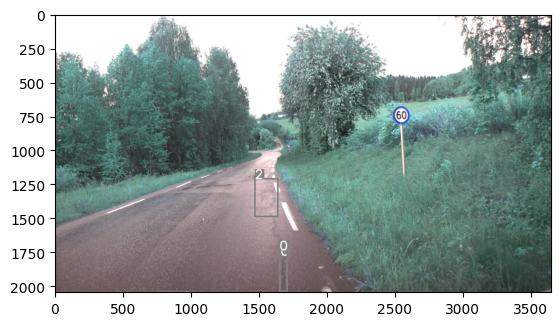

In [20]:
annotator = Annotator(im0)
for box in merged_boxes:
    print(box.xyxy[0])
    b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
    c = box.cls
    annotator.box_label(b, str(int(c.item())))
frame = annotator.result()
plt.imshow(frame)
